# Twitter Sentiment Analysis with Random Forest
## What is Sentiment Analysis?
Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

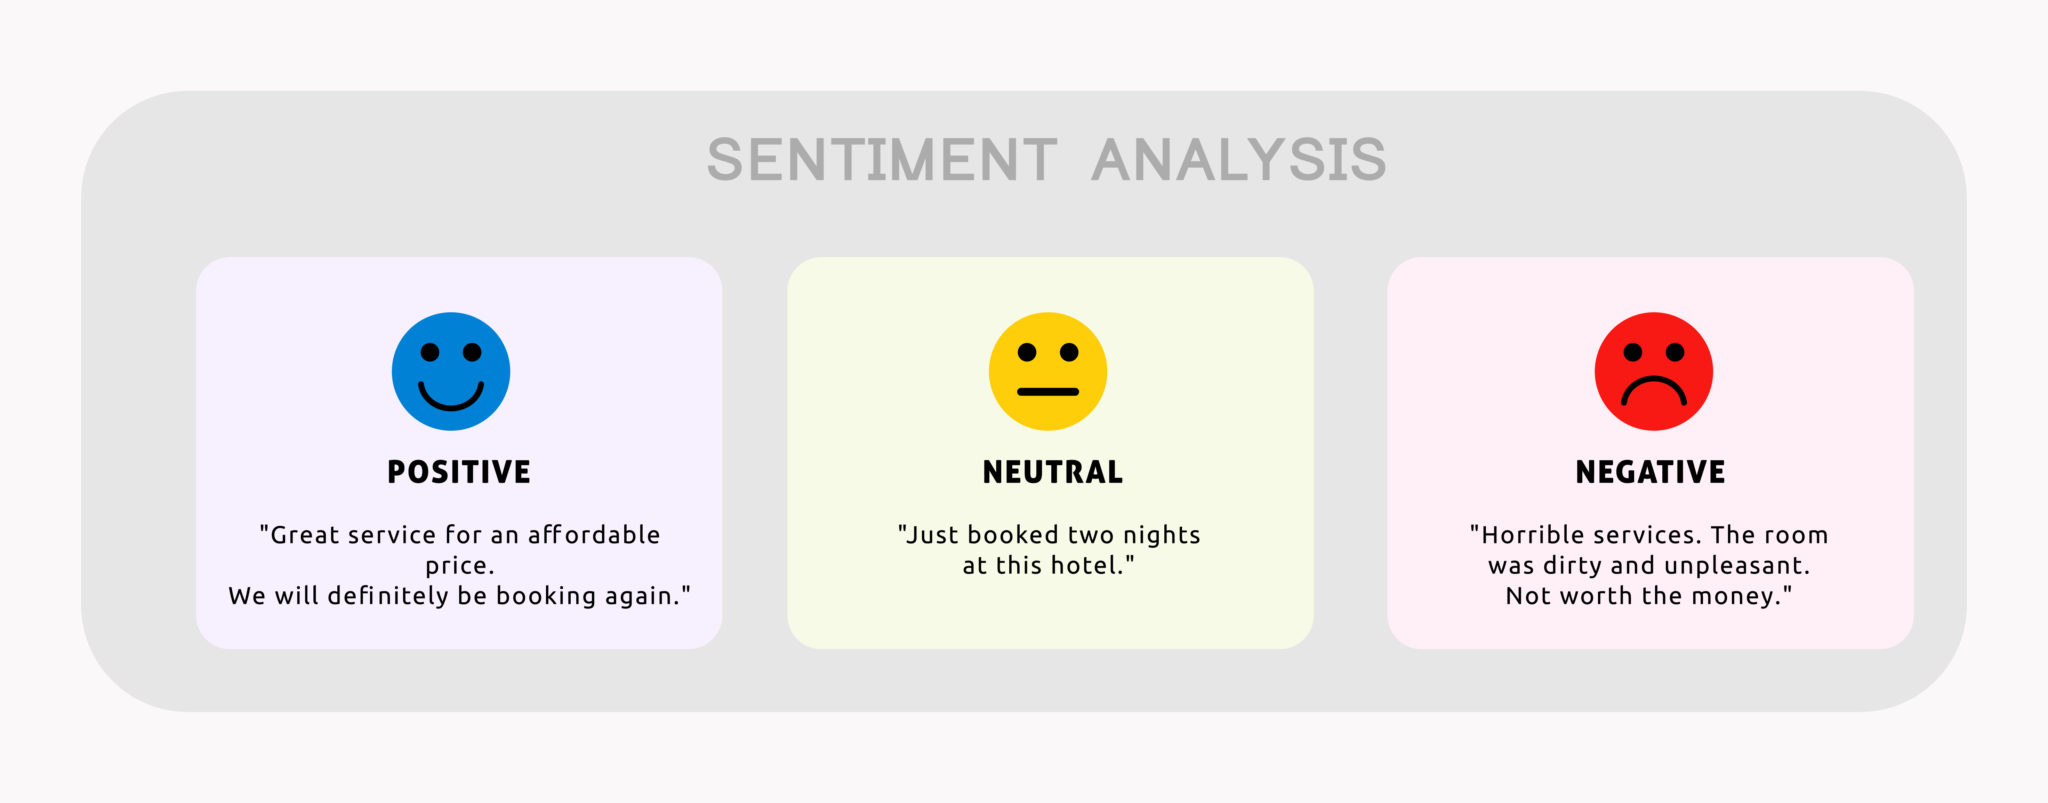

## Random Forest Classifier
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
- [Random Forest Classifier]
- It is supervised learning algorithm.

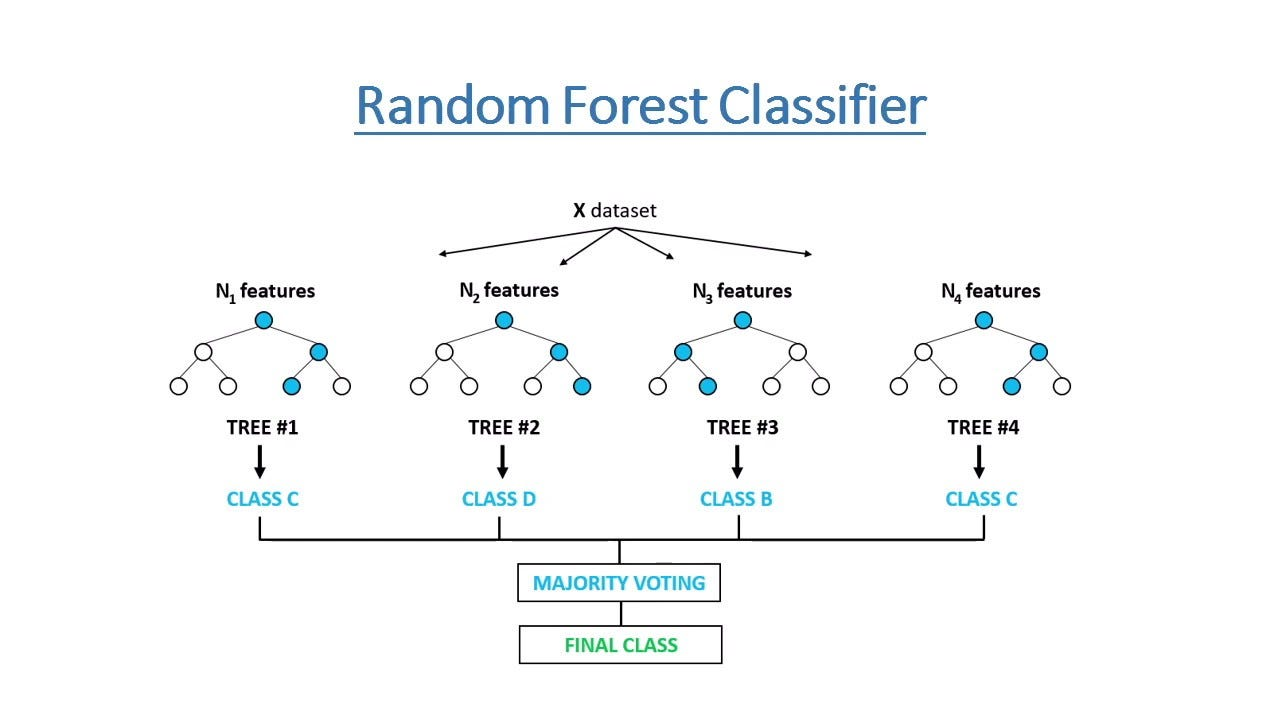

### Pros of Random Forest Classifier
- It is very accurate algorithm.
- It is robust to outliers and nonlinear data.
- It is highly scalable to any dataset size. It can handle large datasets.
- It can handle missing values efficiently.
- It can be used for feature selection.

### Cons of Random Forest Classifier
- It can be computationally expensive when you have a lot of trees.


## Lets Start Coding

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from textblob import TextBlob

In [6]:
def load_data(data: str) -> pd.DataFrame:
    """
    Load the dataset from the provided file path and preprocess it.

    """
    df = pd.read_csv(data, header=None, index_col=[0])
    
    # Selecting only relevant columns (2 and 3), resetting index, and renaming columns
    df = df[[2, 3]].reset_index(drop=True)
    df.columns = ['sentiment', 'text']
    
    # Dropping rows where 'text' is not a string or is NaN
    df['text'] = df['text'].astype(str)  # Convert all text to string
    df = df[df['text'].apply(len) > 1]   # Filter out rows where text length is <= 1
    
    return df

# Load the data
data = r'C:\Users\ephre\Documents\Sentiment Analysis\Data\twitter_sentiment.csv'
df = load_data(data)
df


,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,Positive,Today sucked so it’s time to drink wine n play...
75680,Positive,Bought a fraction of Microsoft today. Small wins.


In [7]:
df.info

<bound method DataFrame.info of         sentiment                                               text
0        Positive  im getting on borderlands and i will murder yo...
1        Positive  I am coming to the borders and I will kill you...
2        Positive  im getting on borderlands and i will kill you ...
3        Positive  im coming on borderlands and i will murder you...
4        Positive  im getting on borderlands 2 and i will murder ...
...           ...                                                ...
75677  Irrelevant  ⭐️ Toronto is the arts and culture capital of ...
75678  Irrelevant  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679    Positive  Today sucked so it’s time to drink wine n play...
75680    Positive  Bought a fraction of Microsoft today. Small wins.
75681     Neutral  Johnson & Johnson to stop selling talc baby po...

[75333 rows x 2 columns]>

In [8]:
df.describe()

,sentiment,text
count,75333,75333
unique,4,69958
top,Negative,nan
freq,22714,686


In [9]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [10]:
class TextCleaner:
    """
    A class to clean and preprocess text data for sentiment analysis and extract useful features.
    """
    def __init__(self):
        self.my_stopwords = set(stopwords.words('english'))

    @staticmethod
    def _remove_html_tags(text: str) -> str:
        """Remove HTML tags from the given text."""
        return BeautifulSoup(text, 'lxml').get_text()

    @staticmethod
    def _remove_urls(text: str) -> str:
        """Remove URLs from the given text."""
        return re.sub(r'http[s]?://\S+', '', text)

    @staticmethod
    def _remove_emails(text: str) -> str:
        """Remove email addresses from the given text."""
        return re.sub(r'\S+@\S+', '', text)

    @staticmethod
    def _remove_special_chars(text: str) -> str:
        """Remove special characters from the given text, leaving only alphanumeric characters and spaces."""
        return re.sub(r'[^A-Za-z0-9\s]', '', text)

    def _remove_stopwords_and_short_words(self, text: str) -> str:
        """
        Remove stopwords and words with less than 5 characters.
        
        Args:
            text (str): The input text.
        
        Returns:
            str: The cleaned text with stopwords and short words removed.
        """
        words = word_tokenize(text)
        filtered_words = [
            word for word in words if word.lower() not in self.my_stopwords and len(word) >= 5
        ]
        return ' '.join(filtered_words)

    def clean_text(self, text: str) -> str:
        """
        Clean and preprocess the text by removing HTML tags, URLs, emails, special characters, stopwords,
        and words shorter than 5 characters.
        
        Args:
            text (str): The input text to clean.

        Returns:
            str: The cleaned text.
        """
        try:
            # Perform cleaning steps sequentially
            text = self._remove_html_tags(text)
            text = self._remove_urls(text)
            text = self._remove_emails(text)
            text = self._remove_special_chars(text)
            text = self._remove_stopwords_and_short_words(text)
        except Exception as e:
            # Log the error and return the original text if something goes wrong
            print(f"Error cleaning text: {e}")
            return text
        return text

    def _count_occurrences(self, text: str, char: str) -> int:
        """Helper function to count occurrences of a specific character (e.g., hashtag, mention) in a string."""
        return len([word for word in text.split() if word.startswith(char)])

    def _average_word_length(self, text: str) -> float:
        """Calculate the average word length in the given text."""
        words = word_tokenize(text)
        if len(words) <= 5:
            return 0
        return sum(len(word) for word in words) / len(words)

    def extract_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Extract basic features such as word count, character count, stopwords count, hashtag count, mention count,
        average word length, unique word count, sentence count, punctuation count, and sentiment score.

        Args:
            df (pd.DataFrame): DataFrame containing a 'text' column with raw text data.

        Returns:
            pd.DataFrame: DataFrame with new feature columns based on the cleaned text.
        """
        # Clean the text data
        df['clean_text'] = df['text'].apply(self.clean_text)

        # Basic text features
        df['word_count'] = df['clean_text'].apply(lambda x: len(word_tokenize(x)) if pd.notnull(x) else 0)
        df['char_count'] = df['clean_text'].apply(lambda x: len(x) if pd.notnull(x) else 0)
        df['stopwords_count'] = df['clean_text'].apply(
            lambda x: len([word for word in word_tokenize(x.lower()) if word in self.my_stopwords]) if pd.notnull(x) else 0
        )
        df['hashtag_count'] = df['text'].apply(lambda x: self._count_occurrences(x, '#') if pd.notnull(x) else 0)
        df['mention_count'] = df['text'].apply(lambda x: self._count_occurrences(x, '@') if pd.notnull(x) else 0)

        # Advanced text features
        df['avg_word_length'] = df['clean_text'].apply(lambda x: self._average_word_length(x) if pd.notnull(x) else 0)
        df['unique_word_count'] = df['clean_text'].apply(lambda x: len(set(word_tokenize(x))) if pd.notnull(x) else 0)
        df['sentence_count'] = df['clean_text'].apply(lambda x: len(sent_tokenize(x)) if pd.notnull(x) else 0)
        df['punctuation_count'] = df['text'].apply(lambda x: len(re.findall(r'[^\w\s]', x)) if pd.notnull(x) else 0)

        # Sentiment Analysis
        df['sentiment_polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notnull(x) else 0)
        df['sentiment_subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity if pd.notnull(x) else 0)

        return df




cleaner = TextCleaner()
df = cleaner.clean_text(df)
df = cleaner.extract_features(df)
df

Error cleaning text: 'DataFrame' object has no attribute 'startswith'


,sentiment,text,clean_text,word_count,char_count,stopwords_count,hashtag_count,mention_count,avg_word_length,unique_word_count,sentence_count,punctuation_count,sentiment_polarity,sentiment_subjectivity
0,Positive,im getting on borderlands and i will murder yo...,getting borderlands murder,3,26,0,0,0,0.000000,3,1,1,0.000,0.000000
1,Positive,I am coming to the borders and I will kill you...,coming borders,2,14,0,0,0,0.000000,2,1,1,0.000,0.000000
2,Positive,im getting on borderlands and i will kill you ...,getting borderlands,2,19,0,0,0,0.000000,2,1,1,0.000,0.000000
3,Positive,im coming on borderlands and i will murder you...,coming borderlands murder,3,25,0,0,0,0.000000,3,1,1,0.000,0.000000
4,Positive,im getting on borderlands 2 and i will murder ...,getting borderlands murder,3,26,0,0,0,0.000000,3,1,1,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75677,Irrelevant,⭐️ Toronto is the arts and culture capital of ...,Toronto culture capital Canada wonder start pl...,14,136,0,0,0,8.785714,14,1,17,0.000,1.000000
75678,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,ACTUALLY BRING VIEWERS people hooked watching ...,13,101,0,0,0,6.846154,13,1,5,0.125,0.216667
75679,Positive,Today sucked so it’s time to drink wine n play...,Today sucked drink borderlands comes tomorrow,6,45,0,0,0,6.666667,6,1,2,0.000,0.000000
75680,Positive,Bought a fraction of Microsoft today. Small wins.,Bought fraction Microsoft today Small,5,37,0,0,0,0.000000,5,1,2,-0.250,0.400000


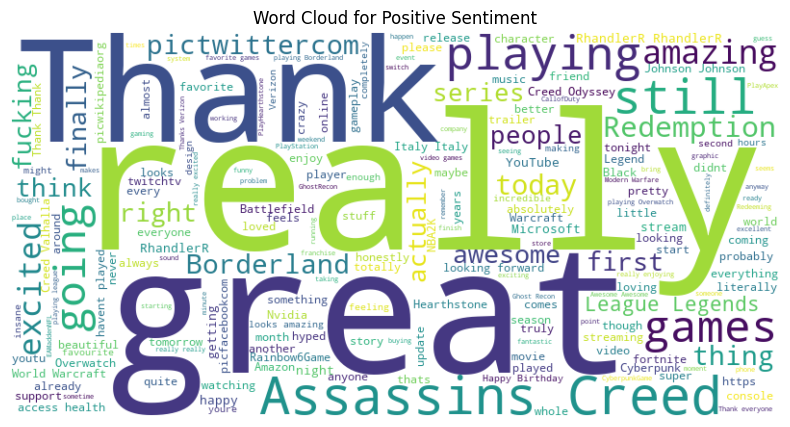

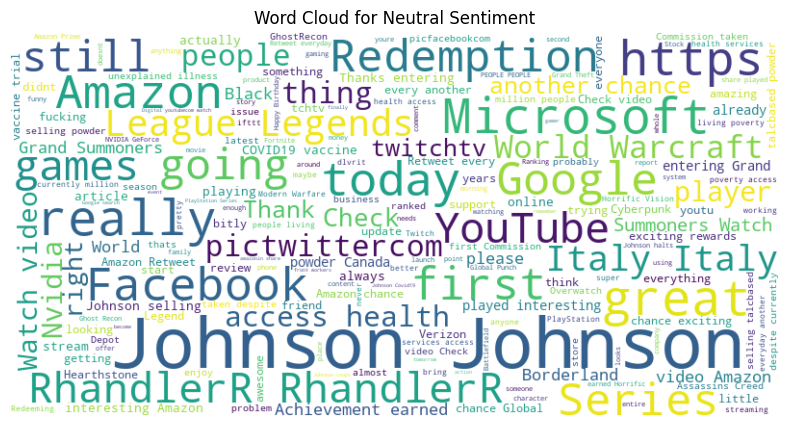

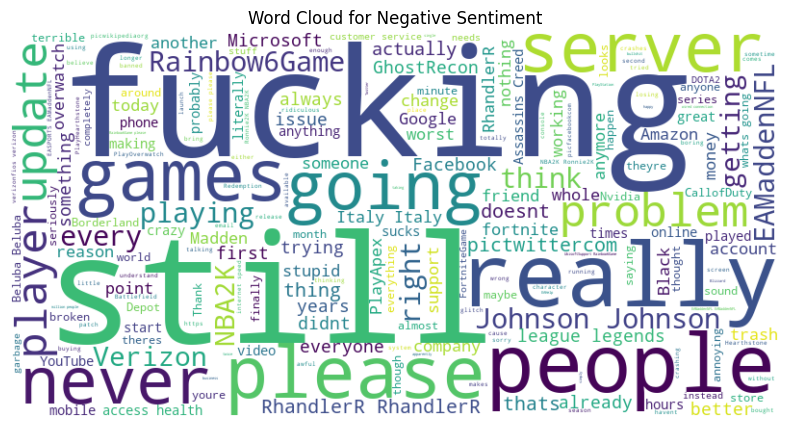

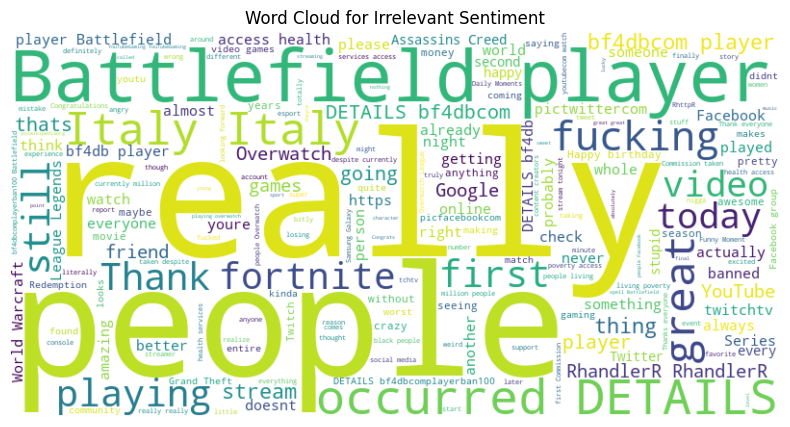

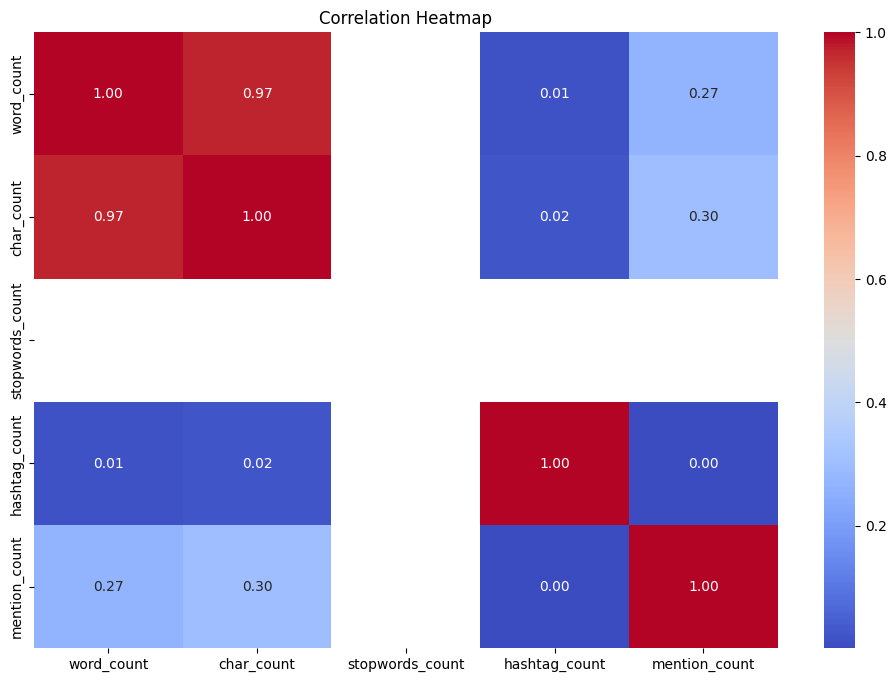

In [11]:
# Function to visualize data
def visualize_data(df: pd.DataFrame) -> None:
    # Word cloud visualization for each sentiment
    for sentiment in df['sentiment'].unique():
        plt.figure(figsize=(10, 5))
        text = " ".join(df[df['sentiment'] == sentiment]['clean_text'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment} Sentiment')
        plt.show()
    # Additional visualization: Heatmap of correlations
    plt.figure(figsize=(12, 8))
    corr = df[['word_count', 'char_count', 'stopwords_count', 'hashtag_count', 'mention_count']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()



visualize_data(df)

In [12]:
class Visualizer:
    """
    A class that handles the creation of visualizations for sentiment analysis and text features.
    """
    
    @staticmethod
    def plot_sentiment_count(df):
        """
        Plot the count of sentiments in the data.

        Args:
            df (pd.DataFrame): DataFrame containing the 'sentiment' column.
        """
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='sentiment', palette='Set2')
        plt.title('Count of Sentiments')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.show()

    @staticmethod
    def plot_word_count_distribution(df):
        """
        Plot the distribution of word count by sentiment using a boxplot.

        Args:
            df (pd.DataFrame): DataFrame containing the 'sentiment' and 'word_count' columns.
        """
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=df, x='sentiment', y='word_count', palette='Set2')
        plt.title('Word Count Distribution by Sentiment')
        plt.xlabel('Sentiment')
        plt.ylabel('Word Count')
        plt.show()

    @staticmethod
    def plot_word_count_histogram(df):
        """
        Plot a histogram of word count distribution, colored by sentiment.

        Args:
            df (pd.DataFrame): DataFrame containing the 'word_count' and 'sentiment' columns.
        """
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='word_count', bins=30, hue='sentiment', multiple='stack')
        plt.title('Word Count Distribution')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_char_count_histogram(df):
        """
        Plot a histogram of character count distribution, colored by sentiment.

        Args:
            df (pd.DataFrame): DataFrame containing the 'char_count' and 'sentiment' columns.
        """
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='char_count', bins=30, hue='sentiment', multiple='stack')
        plt.title('Character Count Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def plot_clean_text_length_distribution(df):
        """
        Plot the distribution of the length of the clean text.

        Args:
            df (pd.DataFrame): DataFrame containing the 'clean_text' column.
        """
        plt.figure(figsize=(12, 6))
        df['clean_text'].str.len().hist(bins=50, color='skyblue')
        plt.title('Distribution of Length of Clean Text')
        plt.xlabel('Length of Clean Text')
        plt.ylabel('Frequency')
        plt.show()


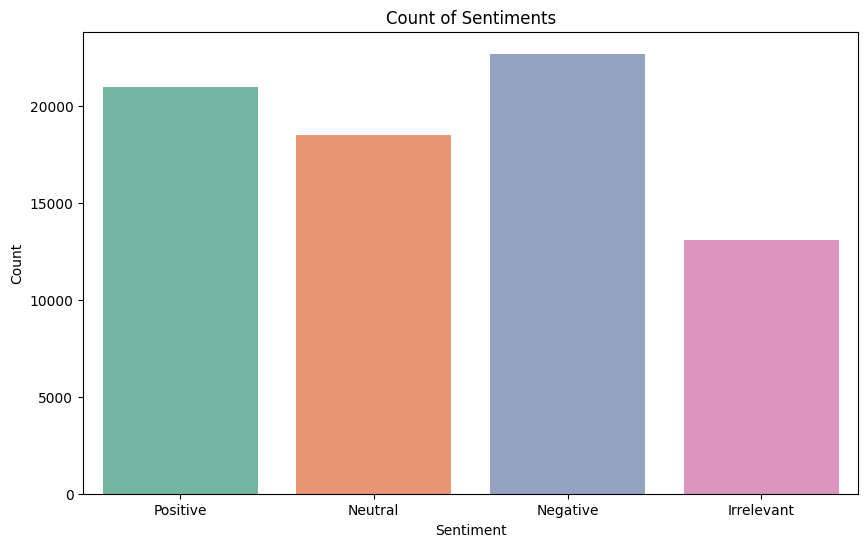

In [13]:
visualize = Visualizer()
visualize.plot_sentiment_count(df)

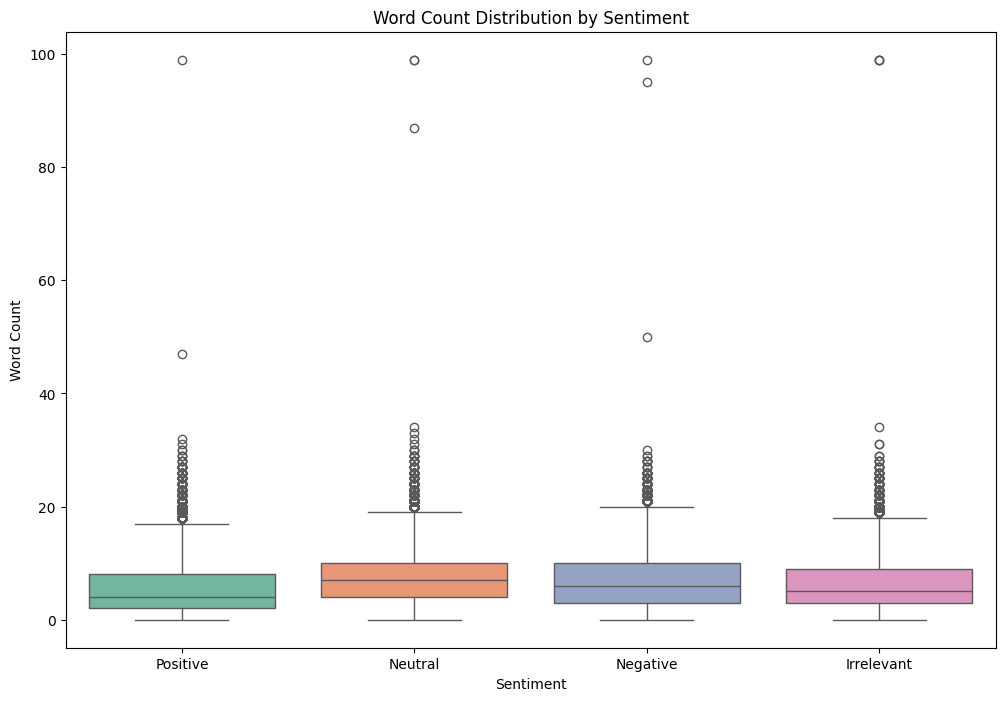

In [14]:
visualize.plot_word_count_distribution(df)

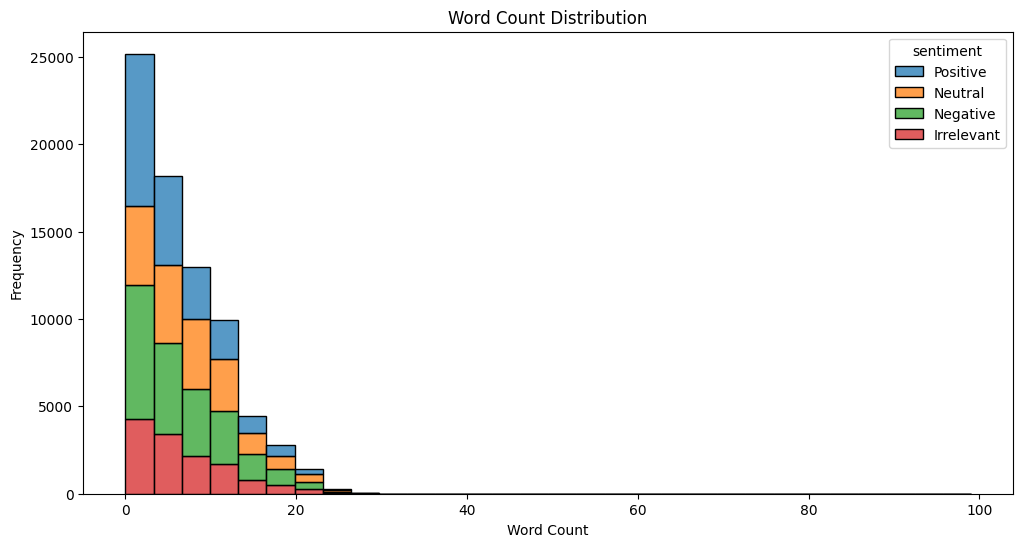

In [15]:
visualize.plot_word_count_histogram(df)

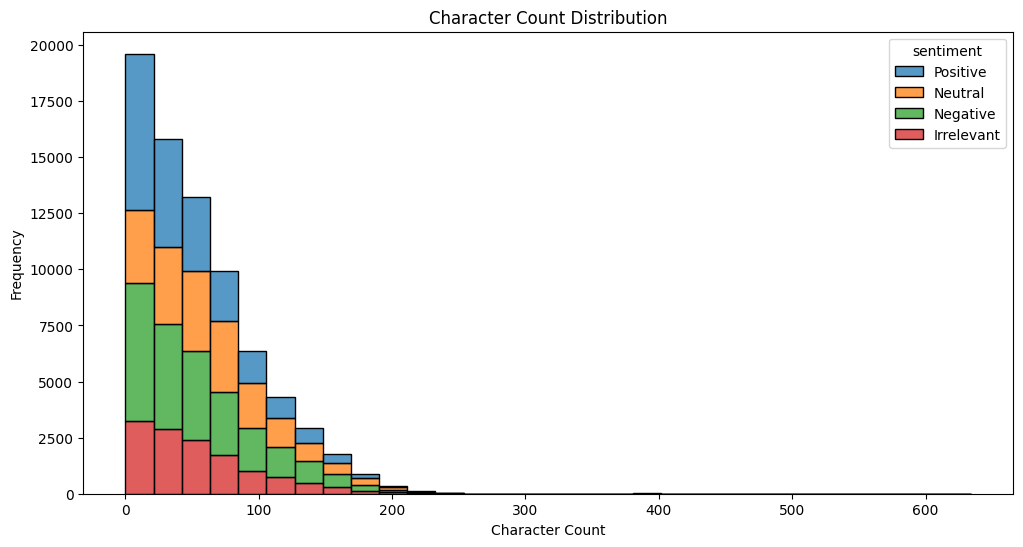

In [16]:
visualize.plot_char_count_histogram(df)

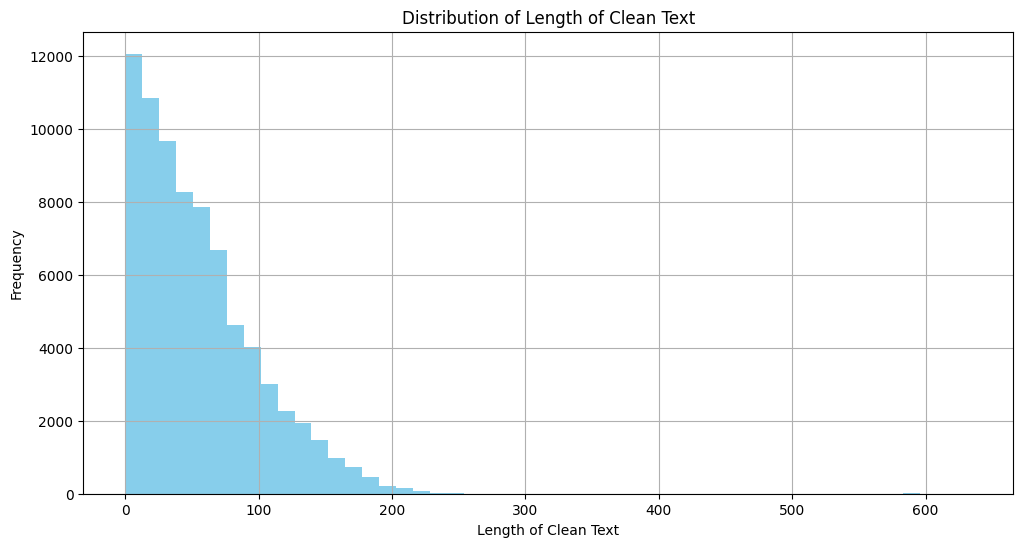

In [17]:
visualize.plot_clean_text_length_distribution(df)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
        df['clean_text'], df['sentiment'], test_size=0.2, random_state=42
    )

Logistic Regression: Mean Accuracy = 0.7591, Std = 0.0034
Random Forest: Mean Accuracy = 0.8633, Std = 0.0031
Gradient Boosting: Mean Accuracy = 0.4600, Std = 0.0078
AdaBoost: Mean Accuracy = 0.4164, Std = 0.0062
Naive Bayes: Mean Accuracy = 0.7124, Std = 0.0036
K-Nearest Neighbors: Mean Accuracy = 0.8073, Std = 0.0073


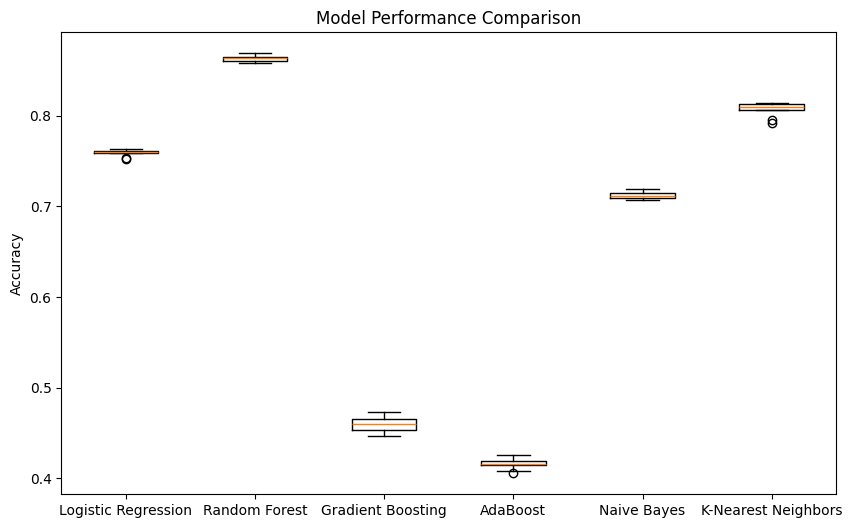

In [19]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_models(X: pd.Series, y: pd.Series) -> None:
    """
    Evaluate and compare different machine learning models.

    Args:
        X (pd.Series): Features.
        y (pd.Series): Labels.
    """
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=75),
        "AdaBoost": AdaBoostClassifier(n_estimators=50),
        "Naive Bayes": MultinomialNB(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
    }

    results = {}
    kfold = KFold(n_splits=10, shuffle=True, random_state=18)

    for name, model in models.items():
        cv_results = cross_val_score(Pipeline([('tfidf', TfidfVectorizer()), ('clf', model)]), 
                                      X, y, cv=kfold, scoring='accuracy')
        results[name] = cv_results
        print(f"{name}: Mean Accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

    # Boxplot of model performance
    plt.figure(figsize=(10, 6))
    plt.boxplot(results.values(), labels=results.keys())
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.show()


# Example call
evaluate_models(df['clean_text'], df['sentiment'])


In [20]:
# Model building function
def build_model(X_train: pd.Series, y_train: pd.Series, model) -> Pipeline:
    """
    Build a machine learning model for sentiment analysis.

    Args:
        X_train (pd.Series): Training features.
        y_train (pd.Series): Training labels.
        model: The machine learning model to use.

    Returns:
        Pipeline: Trained machine learning model pipeline.
    """
    stopwords_list = list(set(stopwords.words('english')))
    clf = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
        ('clf', model)
    ])
    clf.fit(X_train, y_train)
    return clf



final_model = build_model(X_train, y_train, RandomForestClassifier(n_estimators=100))
final_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['your', 'have', 'our',
                                             'yourselves', 'been', 'as',
                                             "didn't", 'themselves', 'himself',
                                             'theirs', 'up', "isn't", 'isn',
                                             "you'd", 'nor', 'was', 'an',
                                             "hadn't", 'haven', 'its',
                                             "mustn't", 'it', 'does', 'don',
                                             'other', "weren't", 'ain', 'than',
                                             'hers', 'his', ...])),
                ('clf', RandomForestClassifier())])

In [21]:
y_pred = final_model.predict(X_test)

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.93      0.80      0.86      2659
    Negative       0.89      0.85      0.87      4511
     Neutral       0.90      0.84      0.87      3696
    Positive       0.77      0.92      0.83      4201

    accuracy                           0.86     15067
   macro avg       0.87      0.85      0.86     15067
weighted avg       0.87      0.86      0.86     15067



In [23]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[2124  132  103  300]
 [  53 3851  103  504]
 [  61  166 3093  376]
 [  50  183  119 3849]]


In [24]:
def save_model(model: Pipeline, filename: str) -> None:
    """
    Save the trained model to a file.

    Args:
        model (Pipeline): Trained machine learning model.
        filename (str): Filename to save the model.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)



save_model(final_model, 'sentiment_model.pkl')